# Importing modules and functions

In [9]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from copy import deepcopy
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [10]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [11]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [13]:
# Set file path
df_ws=pd.read_csv('datasets/rat_oral_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326
...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647


##  Standardization  for work set

In [15]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
print('Kept data: ', len(df_ws), 'molecules')

[08:17:54] Unusual charge on atom 8 number of radical electrons set to zero
[08:17:54] Unusual charge on atom 0 number of radical electrons set to zero
[08:17:54] Unusual charge on atom 16 number of radical electrons set to zero
[08:17:54] Unusual charge on atom 16 number of radical electrons set to zero


Kept data:  7874 molecules


In [16]:
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8D...
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8D...
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8D...
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8D...
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8D...
...,...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8F...
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8F...
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8F...
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647,<rdkit.Chem.rdchem.Mol object at 0x0000029BA8F...


In [17]:
y_tr=df_ws.rat_oral_LD50	
y_tr

0       0.291207
1       0.440661
2       0.537456
3       0.539248
4       0.580326
          ...   
7869    6.698777
7870    6.937118
7871    7.099681
7872    7.602647
7873    9.541127
Name: rat_oral_LD50, Length: 7874, dtype: float64

In [18]:
moldf_ws=df_ws.Molecule

##  Load data and curation test set

In [20]:
df_ts=pd.read_csv('datasets/rat_oral_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711
...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876


##  Standardization  for test set

In [22]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1969 molecules


In [23]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
...,...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876,<rdkit.Chem.rdchem.Mol object at 0x0000029BA90...


In [24]:
y_ts=moldf_ts.rat_oral_LD50
y_ts

0       0.017765
1       0.572835
2       0.624488
3       0.686956
4       0.750711
          ...   
1964    5.931904
1965    5.991624
1966    6.238094
1967    6.401876
1968    7.206791
Name: rat_oral_LD50, Length: 1969, dtype: float64

In [25]:
moldf_ts=moldf_ts.Molecule

## Calculation MACCS Fingerprints for work set

In [27]:
fp_tr = [MACCSkeys.GenMACCSKeys(m) for m in moldf_ws]

In [28]:
def rdkit_numpy_convert(fp_tr):
    output = []
    for f in fp_tr:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)        
        output.append(arr)
    return np.asarray(output)

In [29]:
from numpy import savetxt
x_tr = rdkit_numpy_convert(fp_tr)

In [30]:
columns = [f"MACCS_key_{i}" for i in range(167)]

In [31]:
df_RDKit_2D = pd.DataFrame(x_tr, columns=columns)

In [32]:
df_RDKit_2D

,MACCS_key_0,MACCS_key_1,MACCS_key_2,MACCS_key_3,MACCS_key_4,MACCS_key_5,MACCS_key_6,MACCS_key_7,MACCS_key_8,MACCS_key_9,...,MACCS_key_157,MACCS_key_158,MACCS_key_159,MACCS_key_160,MACCS_key_161,MACCS_key_162,MACCS_key_163,MACCS_key_164,MACCS_key_165,MACCS_key_166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
7870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
7871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
7872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [33]:
(df_RDKit_2D.iloc[:, 3]==1).sum()

125

In [34]:
savetxt('models/MACCS/x_tr_MACCS.csv', x_tr, delimiter=',')

In [35]:
x_tr.shape

(7874, 167)

## Calculation  MACCS Fingerprint for test set

In [37]:
fp_ts = [MACCSkeys.GenMACCSKeys(m) for m in moldf_ts]

In [38]:
def rdkit_numpy_convert(fp_ts):
    output = []
    for f in fp_ts:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [39]:
x_ts = rdkit_numpy_convert(fp_ts)

In [40]:
x_ts.shape

(1969, 167)

In [45]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

# CatBoostRegressor

In [83]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [280]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 8min
Wall time: 15min 20s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000026D99634260>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [281]:
best_CatBR = grid.best_estimator_

In [284]:
grid.best_params_

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.05}

In [285]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [286]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.92

In [287]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.26

In [86]:
params={'verbose': False}

In [293]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

CPU times: total: 35min 17s
Wall time: 3min 28s


In [296]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.58

In [297]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.58

# save the model to disk

In [174]:
pickle.dump(best_CatBR, open('Models/MACCS/Toxicity_CatBoost_MACCS.pkl', 'wb'))

# load the model from disk

In [72]:
best_CatBR = pickle.load(open('Models/MACCS/Toxicity_CatBoost_MACCS.pkl', 'rb'))

# 9. Prediction for test set's molecules

In [75]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [77]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [79]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.61

In [81]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.56

# Calculate Feature Importance

In [95]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': df_RDKit_2D.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

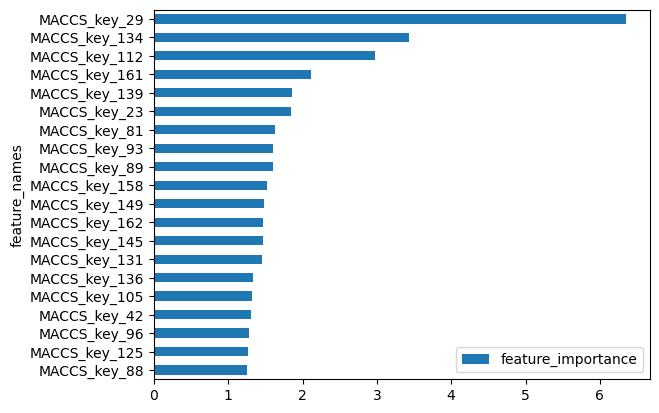

In [97]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

# Y-randomization GradientBoostingRegressor model

In [88]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_CatBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=42)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

True score =  0.58 
Y-randomization =  -0.17 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [304]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [305]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,4.358899,1.732051,2.236068,2.000000,2.645751,2.236068,2.645751,0.000000,0.000000,...,1.000000,2.000000,2.236068,3.162278,2.000000,1.414214,2.828427,2.449490,3.000000,2.236068
2,1.732051,4.690416,1.732051,2.236068,2.449490,3.162278,3.000000,2.828427,0.000000,0.000000,...,2.449490,2.645751,4.358899,3.162278,2.449490,1.414214,3.162278,2.449490,3.162278,2.449490
3,2.449490,4.690416,1.732051,2.449490,2.645751,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,2.449490,3.000000,3.162278,3.162278,3.316625,2.449490
4,3.162278,4.795832,1.732051,2.449490,2.828427,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,3.000000,3.162278,3.316625,3.464102,3.464102,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,8.366600,8.544003,9.327379,8.944272,9.219544,8.888194,8.944272,9.219544,9.110434,9.327379,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,8.944272,8.485281,9.000000
7870,8.426149,8.602325,9.327379,8.944272,9.219544,8.944272,9.000000,9.273619,9.165152,9.539392,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,9.000000,8.544003,9.055386
7871,8.485281,8.717798,9.380832,9.000000,9.219544,8.944272,9.000000,9.327379,9.273619,9.539392,...,8.831760,8.660254,8.602325,8.774964,9.000000,9.219544,8.831760,9.110434,8.544003,9.055386
7872,8.485281,8.717798,9.433981,9.000000,9.327379,9.055386,9.000000,9.380832,9.327379,9.539392,...,8.888194,8.717798,8.602325,8.774964,9.055386,9.273619,8.944272,9.219544,8.602325,9.110434


In [306]:
similarity= neighbors_k

In [307]:
Dmean=np.mean(similarity[1,:])

In [308]:
round(Dmean, 2)

2.02

In [309]:
std=np.std(similarity[1,:])

In [310]:
round(std, 2)

1.11

In [311]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.58


In [312]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [313]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.414214,2.236068,3.000000,0.000000,2.000000,0.000000,1.732051,1.414214,1.000000,1.414214,...,2.828427,3.605551,2.828427,0.000000,1.414214,3.162278,2.449490,0.000000,3.741657,0.000000
1,1.732051,2.449490,3.000000,0.000000,2.449490,1.000000,2.645751,1.732051,1.732051,1.732051,...,3.162278,4.000000,3.872983,0.000000,2.449490,3.162278,3.162278,0.000000,5.000000,0.000000
2,1.732051,2.828427,3.316625,0.000000,2.645751,1.414214,3.162278,2.449490,2.449490,1.732051,...,3.316625,4.358899,4.000000,1.414214,2.449490,3.741657,3.316625,1.414214,5.099020,1.414214
3,1.732051,3.000000,3.316625,0.000000,2.828427,1.414214,3.464102,2.645751,2.449490,1.732051,...,3.464102,4.358899,4.000000,2.828427,2.449490,3.741657,3.464102,2.828427,5.099020,2.828427
4,1.732051,3.000000,3.464102,0.000000,2.828427,1.414214,3.464102,2.828427,2.645751,2.000000,...,3.605551,4.358899,4.123106,3.316625,3.000000,4.358899,3.464102,3.316625,5.196152,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,9.165152,9.110434,8.660254,9.110434,9.327379,9.380832,9.000000,9.273619,9.165152,9.000000,...,8.485281,8.774964,8.602325,9.055386,9.000000,8.306623,8.888194,9.055386,8.366600,9.055386
7870,9.273619,9.165152,8.660254,9.165152,9.327379,9.380832,9.055386,9.273619,9.165152,9.000000,...,8.485281,8.831760,8.602325,9.110434,9.000000,8.426149,8.888194,9.110434,8.426149,9.110434
7871,9.380832,9.273619,8.717798,9.273619,9.327379,9.433981,9.055386,9.273619,9.165152,9.055386,...,8.485281,8.831760,8.602325,9.219544,9.055386,8.426149,8.944272,9.219544,8.426149,9.219544
7872,9.380832,9.327379,8.717798,9.327379,9.433981,9.486833,9.165152,9.273619,9.219544,9.165152,...,8.544003,8.944272,8.660254,9.273619,9.273619,8.426149,8.944272,9.273619,8.426149,9.273619


In [314]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.414 2.236 3.    ... 0.    3.742 0.   ]


In [315]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False ...  True False  True]


In [316]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.67


In [317]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    3 ... 1965 1966 1968]


In [318]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [366]:
y_pred_GBR_ad=list(y_pred_GBR)

In [368]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [370]:
len(y_pred_GBR_ad)

1327

In [372]:
y_ts_ad=list(y_ts)

In [374]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [376]:
len(y_ts_ad)

1327

In [378]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.7

In [380]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.5

# SVM model building and validation

In [92]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [54]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [94]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [95]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [96]:
svm.best_params_
best_svm = svm.best_estimator_

In [97]:
svm.best_params_

{'C': 1, 'gamma': 0.1}

In [98]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [99]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.83

In [100]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.37

In [101]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [102]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.56

In [103]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.6

# Prediction for test set's molecules

In [58]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [60]:
y_pred_svm = best_svm.predict(x_ts)

In [62]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.57

In [64]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.58

save the model to disk

In [108]:
pickle.dump(best_svm, open('models/MACCS/Toxicity_SVM_MACCS.pkl', 'wb'))

load the model from disk

In [56]:
best_svm = pickle.load(open('models/MACCS/Toxicity_SVM_MACCS.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [109]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [110]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,4.358899,1.732051,2.236068,2.000000,2.645751,2.236068,2.645751,0.000000,0.000000,...,1.000000,2.000000,2.236068,3.162278,2.000000,1.414214,2.828427,2.449490,3.000000,2.236068
2,1.732051,4.690416,1.732051,2.236068,2.449490,3.162278,3.000000,2.828427,0.000000,0.000000,...,2.449490,2.645751,4.358899,3.162278,2.449490,1.414214,3.162278,2.449490,3.162278,2.449490
3,2.449490,4.690416,1.732051,2.449490,2.645751,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,2.449490,3.000000,3.162278,3.162278,3.316625,2.449490
4,3.162278,4.795832,1.732051,2.449490,2.828427,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,3.000000,3.162278,3.316625,3.464102,3.464102,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,8.366600,8.544003,9.327379,8.944272,9.219544,8.888194,8.944272,9.219544,9.110434,9.327379,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,8.944272,8.485281,9.000000
7870,8.426149,8.602325,9.327379,8.944272,9.219544,8.944272,9.000000,9.273619,9.165152,9.539392,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,9.000000,8.544003,9.055386
7871,8.485281,8.717798,9.380832,9.000000,9.219544,8.944272,9.000000,9.327379,9.273619,9.539392,...,8.831760,8.660254,8.602325,8.774964,9.000000,9.219544,8.831760,9.110434,8.544003,9.055386
7872,8.485281,8.717798,9.433981,9.000000,9.327379,9.055386,9.000000,9.380832,9.327379,9.539392,...,8.888194,8.717798,8.602325,8.774964,9.055386,9.273619,8.944272,9.219544,8.602325,9.110434


In [111]:
similarity= neighbors_k

In [112]:
Dmean=np.mean(similarity[1,:])

In [113]:
round(Dmean, 2)

2.02

In [114]:
std=np.std(similarity[1,:])

In [115]:
round(std, 2)

1.11

In [116]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.58


In [117]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [118]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.414214,2.236068,3.000000,0.000000,2.000000,0.000000,1.732051,1.414214,1.000000,1.414214,...,2.828427,3.605551,2.828427,0.000000,1.414214,3.162278,2.449490,0.000000,3.741657,0.000000
1,1.732051,2.449490,3.000000,0.000000,2.449490,1.000000,2.645751,1.732051,1.732051,1.732051,...,3.162278,4.000000,3.872983,0.000000,2.449490,3.162278,3.162278,0.000000,5.000000,0.000000
2,1.732051,2.828427,3.316625,0.000000,2.645751,1.414214,3.162278,2.449490,2.449490,1.732051,...,3.316625,4.358899,4.000000,1.414214,2.449490,3.741657,3.316625,1.414214,5.099020,1.414214
3,1.732051,3.000000,3.316625,0.000000,2.828427,1.414214,3.464102,2.645751,2.449490,1.732051,...,3.464102,4.358899,4.000000,2.828427,2.449490,3.741657,3.464102,2.828427,5.099020,2.828427
4,1.732051,3.000000,3.464102,0.000000,2.828427,1.414214,3.464102,2.828427,2.645751,2.000000,...,3.605551,4.358899,4.123106,3.316625,3.000000,4.358899,3.464102,3.316625,5.196152,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,9.165152,9.110434,8.660254,9.110434,9.327379,9.380832,9.000000,9.273619,9.165152,9.000000,...,8.485281,8.774964,8.602325,9.055386,9.000000,8.306623,8.888194,9.055386,8.366600,9.055386
7870,9.273619,9.165152,8.660254,9.165152,9.327379,9.380832,9.055386,9.273619,9.165152,9.000000,...,8.485281,8.831760,8.602325,9.110434,9.000000,8.426149,8.888194,9.110434,8.426149,9.110434
7871,9.380832,9.273619,8.717798,9.273619,9.327379,9.433981,9.055386,9.273619,9.165152,9.055386,...,8.485281,8.831760,8.602325,9.219544,9.055386,8.426149,8.944272,9.219544,8.426149,9.219544
7872,9.380832,9.327379,8.717798,9.327379,9.433981,9.486833,9.165152,9.273619,9.219544,9.165152,...,8.544003,8.944272,8.660254,9.273619,9.273619,8.426149,8.944272,9.273619,8.426149,9.273619


In [119]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.414 2.236 3.    ... 0.    3.742 0.   ]


In [120]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False ...  True False  True]


In [121]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.67


In [122]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    3 ... 1965 1966 1968]


In [123]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [124]:
y_pred_svm_ad=list(y_pred_svm)

In [125]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [126]:
len(y_pred_svm_ad)

1327

In [127]:
y_ts_ad=list(y_ts)

In [128]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [129]:
len(y_ts_ad)

1327

In [130]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.67

In [131]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.53

# Multi-layer Perceptron regressor

In [132]:
from sklearn.neural_network import MLPRegressor

In [133]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [134]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [135]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [136]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [137]:
best_MLPR = m.best_estimator_

In [138]:
m.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'adam'}

In [139]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [140]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.96

In [141]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.18

In [142]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [143]:
y_pred_CV_MLPR

array([1.2566378, 3.3188913, 1.4009999, ..., 4.4459443, 2.6433103,
       2.3763356], dtype=float32)

In [144]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.5

In [145]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.63

# Prediction for test set's molecules

In [146]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [147]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [148]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.49

In [149]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.64

# save the model to disk

In [150]:
pickle.dump(best_MLPR, open('models/MACCS/Toxicity_MLPR_MACCS.pkl', 'wb'))

# load the model from disk

In [83]:
best_MLPR = pickle.load(open('models/MACCS/Toxicity_MLPR_MACCS.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [151]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [152]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,4.358899,1.732051,2.236068,2.000000,2.645751,2.236068,2.645751,0.000000,0.000000,...,1.000000,2.000000,2.236068,3.162278,2.000000,1.414214,2.828427,2.449490,3.000000,2.236068
2,1.732051,4.690416,1.732051,2.236068,2.449490,3.162278,3.000000,2.828427,0.000000,0.000000,...,2.449490,2.645751,4.358899,3.162278,2.449490,1.414214,3.162278,2.449490,3.162278,2.449490
3,2.449490,4.690416,1.732051,2.449490,2.645751,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,2.449490,3.000000,3.162278,3.162278,3.316625,2.449490
4,3.162278,4.795832,1.732051,2.449490,2.828427,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,3.000000,3.162278,3.316625,3.464102,3.464102,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,8.366600,8.544003,9.327379,8.944272,9.219544,8.888194,8.944272,9.219544,9.110434,9.327379,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,8.944272,8.485281,9.000000
7870,8.426149,8.602325,9.327379,8.944272,9.219544,8.944272,9.000000,9.273619,9.165152,9.539392,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,9.000000,8.544003,9.055386
7871,8.485281,8.717798,9.380832,9.000000,9.219544,8.944272,9.000000,9.327379,9.273619,9.539392,...,8.831760,8.660254,8.602325,8.774964,9.000000,9.219544,8.831760,9.110434,8.544003,9.055386
7872,8.485281,8.717798,9.433981,9.000000,9.327379,9.055386,9.000000,9.380832,9.327379,9.539392,...,8.888194,8.717798,8.602325,8.774964,9.055386,9.273619,8.944272,9.219544,8.602325,9.110434


In [153]:
similarity= neighbors_k

In [154]:
Dmean=np.mean(similarity[1,:])

In [155]:
round(Dmean, 2)

2.02

In [156]:
std=np.std(similarity[1,:])

In [157]:
round(std, 2)

1.11

In [158]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.58


In [159]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [160]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.414214,2.236068,3.000000,0.000000,2.000000,0.000000,1.732051,1.414214,1.000000,1.414214,...,2.828427,3.605551,2.828427,0.000000,1.414214,3.162278,2.449490,0.000000,3.741657,0.000000
1,1.732051,2.449490,3.000000,0.000000,2.449490,1.000000,2.645751,1.732051,1.732051,1.732051,...,3.162278,4.000000,3.872983,0.000000,2.449490,3.162278,3.162278,0.000000,5.000000,0.000000
2,1.732051,2.828427,3.316625,0.000000,2.645751,1.414214,3.162278,2.449490,2.449490,1.732051,...,3.316625,4.358899,4.000000,1.414214,2.449490,3.741657,3.316625,1.414214,5.099020,1.414214
3,1.732051,3.000000,3.316625,0.000000,2.828427,1.414214,3.464102,2.645751,2.449490,1.732051,...,3.464102,4.358899,4.000000,2.828427,2.449490,3.741657,3.464102,2.828427,5.099020,2.828427
4,1.732051,3.000000,3.464102,0.000000,2.828427,1.414214,3.464102,2.828427,2.645751,2.000000,...,3.605551,4.358899,4.123106,3.316625,3.000000,4.358899,3.464102,3.316625,5.196152,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,9.165152,9.110434,8.660254,9.110434,9.327379,9.380832,9.000000,9.273619,9.165152,9.000000,...,8.485281,8.774964,8.602325,9.055386,9.000000,8.306623,8.888194,9.055386,8.366600,9.055386
7870,9.273619,9.165152,8.660254,9.165152,9.327379,9.380832,9.055386,9.273619,9.165152,9.000000,...,8.485281,8.831760,8.602325,9.110434,9.000000,8.426149,8.888194,9.110434,8.426149,9.110434
7871,9.380832,9.273619,8.717798,9.273619,9.327379,9.433981,9.055386,9.273619,9.165152,9.055386,...,8.485281,8.831760,8.602325,9.219544,9.055386,8.426149,8.944272,9.219544,8.426149,9.219544
7872,9.380832,9.327379,8.717798,9.327379,9.433981,9.486833,9.165152,9.273619,9.219544,9.165152,...,8.544003,8.944272,8.660254,9.273619,9.273619,8.426149,8.944272,9.273619,8.426149,9.273619


In [161]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.414 2.236 3.    ... 0.    3.742 0.   ]


In [162]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False ...  True False  True]


In [163]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.67


In [164]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    3 ... 1965 1966 1968]


In [165]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [166]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [167]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [168]:
len(y_pred_MLPR_ad)

1327

In [169]:
y_ts_ad=list(y_ts)

In [170]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [171]:
len(y_ts_ad)

1327

In [172]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.62

In [193]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.57

# k-nearest neighbors

In [195]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [196]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [197]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [198]:
best_kNN = m.best_estimator_

In [199]:
m.best_params_

{'n_neighbors': 5}

In [200]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [201]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.68

In [202]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.51

In [203]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [204]:
y_pred_CV_kNN

array([1.4258754, 2.7924078, 1.3673575, ..., 3.515985 , 2.58842  ,
       2.4945967], dtype=float32)

In [205]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.49

In [206]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.64

# 9. Prediction for test set's molecules

In [207]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [208]:
y_pred_kNN = best_kNN.predict(x_ts)

In [209]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.54

In [210]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.61

# save the model to disk

In [211]:
pickle.dump(best_kNN, open('models/MACCS/Toxicity_kNN_MACCS.pkl', 'wb'))

# load the model from disk

In [190]:
best_kNN = pickle.load(open('models/MACCS/Toxicity_kNN_MACCS.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [212]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [213]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,4.358899,1.732051,2.236068,2.000000,2.645751,2.236068,2.645751,0.000000,0.000000,...,1.000000,2.000000,2.236068,3.162278,2.000000,1.414214,2.828427,2.449490,3.000000,2.236068
2,1.732051,4.690416,1.732051,2.236068,2.449490,3.162278,3.000000,2.828427,0.000000,0.000000,...,2.449490,2.645751,4.358899,3.162278,2.449490,1.414214,3.162278,2.449490,3.162278,2.449490
3,2.449490,4.690416,1.732051,2.449490,2.645751,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,2.449490,3.000000,3.162278,3.162278,3.316625,2.449490
4,3.162278,4.795832,1.732051,2.449490,2.828427,3.162278,3.162278,3.000000,0.000000,0.000000,...,3.000000,2.645751,4.472136,3.464102,3.000000,3.162278,3.316625,3.464102,3.464102,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,8.366600,8.544003,9.327379,8.944272,9.219544,8.888194,8.944272,9.219544,9.110434,9.327379,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,8.944272,8.485281,9.000000
7870,8.426149,8.602325,9.327379,8.944272,9.219544,8.944272,9.000000,9.273619,9.165152,9.539392,...,8.774964,8.660254,8.544003,8.774964,9.000000,9.110434,8.717798,9.000000,8.544003,9.055386
7871,8.485281,8.717798,9.380832,9.000000,9.219544,8.944272,9.000000,9.327379,9.273619,9.539392,...,8.831760,8.660254,8.602325,8.774964,9.000000,9.219544,8.831760,9.110434,8.544003,9.055386
7872,8.485281,8.717798,9.433981,9.000000,9.327379,9.055386,9.000000,9.380832,9.327379,9.539392,...,8.888194,8.717798,8.602325,8.774964,9.055386,9.273619,8.944272,9.219544,8.602325,9.110434


In [214]:
similarity= neighbors_k

In [215]:
Dmean=np.mean(similarity[1,:])

In [216]:
round(Dmean, 2)

2.02

In [217]:
std=np.std(similarity[1,:])

In [218]:
round(std, 2)

1.11

In [219]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.58


In [220]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [221]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,1.414214,2.236068,3.000000,0.000000,2.000000,0.000000,1.732051,1.414214,1.000000,1.414214,...,2.828427,3.605551,2.828427,0.000000,1.414214,3.162278,2.449490,0.000000,3.741657,0.000000
1,1.732051,2.449490,3.000000,0.000000,2.449490,1.000000,2.645751,1.732051,1.732051,1.732051,...,3.162278,4.000000,3.872983,0.000000,2.449490,3.162278,3.162278,0.000000,5.000000,0.000000
2,1.732051,2.828427,3.316625,0.000000,2.645751,1.414214,3.162278,2.449490,2.449490,1.732051,...,3.316625,4.358899,4.000000,1.414214,2.449490,3.741657,3.316625,1.414214,5.099020,1.414214
3,1.732051,3.000000,3.316625,0.000000,2.828427,1.414214,3.464102,2.645751,2.449490,1.732051,...,3.464102,4.358899,4.000000,2.828427,2.449490,3.741657,3.464102,2.828427,5.099020,2.828427
4,1.732051,3.000000,3.464102,0.000000,2.828427,1.414214,3.464102,2.828427,2.645751,2.000000,...,3.605551,4.358899,4.123106,3.316625,3.000000,4.358899,3.464102,3.316625,5.196152,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,9.165152,9.110434,8.660254,9.110434,9.327379,9.380832,9.000000,9.273619,9.165152,9.000000,...,8.485281,8.774964,8.602325,9.055386,9.000000,8.306623,8.888194,9.055386,8.366600,9.055386
7870,9.273619,9.165152,8.660254,9.165152,9.327379,9.380832,9.055386,9.273619,9.165152,9.000000,...,8.485281,8.831760,8.602325,9.110434,9.000000,8.426149,8.888194,9.110434,8.426149,9.110434
7871,9.380832,9.273619,8.717798,9.273619,9.327379,9.433981,9.055386,9.273619,9.165152,9.055386,...,8.485281,8.831760,8.602325,9.219544,9.055386,8.426149,8.944272,9.219544,8.426149,9.219544
7872,9.380832,9.327379,8.717798,9.327379,9.433981,9.486833,9.165152,9.273619,9.219544,9.165152,...,8.544003,8.944272,8.660254,9.273619,9.273619,8.426149,8.944272,9.273619,8.426149,9.273619


In [222]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.414 2.236 3.    ... 0.    3.742 0.   ]


In [223]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True False ...  True False  True]


In [224]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.67


In [225]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    3 ... 1965 1966 1968]


In [226]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [227]:
y_pred_kNN_ad=list(y_pred_kNN)

In [228]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [229]:
len(y_pred_kNN_ad)

1327

In [230]:
y_ts_ad=list(y_ts)

In [231]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [232]:
len(y_ts_ad)

1327

In [233]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.64

In [234]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.56